In [39]:
import math
import numpy as np
import pandas as pd
import os
from csv import writer

import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2

In [40]:
import torch
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
from chitra.image import Chitra
# from pathlib import Path

In [41]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [42]:
def divide(x) :
    if type(x) != 'str' :
        return float(math.floor(x / 8))
    return x

In [43]:
train = pd.read_csv('bboxes_separadas.csv')

In [ ]:
for n, file in enumerate(myFileList):
    img_file = cv2.imread(file)
    df_temp = df[df['imName'] == file[-21:-4]]
    img_grey = cv2.cvtColor(img_file, cv2.COLOR_BGR2GRAY)
    for row,j in df_temp.iterrows():
        #print(type(j[1]))
        if math.isnan(j[1]):
            pass
        else:
            img_rec = cv2.rectangle(img_file, (int(j[1])-30, int(j[2]+30)),
                                (int(j[1])+30, int(j[2]-30)),
                                (0, 255, 0),
                                2)
    img_file = cv2.resize(img_file,(width, height))
    img_grey = cv2.cvtColor(img_file, cv2.COLOR_BGR2GRAY)
        #plt.imshow(img_rec.astype("uint8"))

## GET bboxes

In [6]:
train = pd.read_csv('bboxes_separadas.csv')
train = train.drop(columns = 'Unnamed: 0')

In [ ]:
im_names = train['imName'].unique()[:5000]
folder = 'data/low_resolution/'
step = 25
for batch in range(0,len(im_names),step):
    print(batch)
    box_list = []
    for i in im_names[batch:batch + step]:
        box_list.append(read_image(folder+i+'.JPG'))

    weights_faster = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    transforms = weights_faster.transforms()

    images = [transforms(d) for d in box_list]

    model_1 = fasterrcnn_resnet50_fpn(weights=weights_faster, progress=False)
    model_1 = model_1.eval()

    bbox_modeled_faster = model_1(images)

    train_tmp = pd.DataFrame()
    for z in range(0,len(bbox_modeled_faster)):
        with torch.no_grad():
            arr = bbox_modeled_faster[z]['boxes'].numpy()
            for j in arr:
                x1 = j[0]
                y1 = j[1]
                x2 = j[2]
                y2 = j[3]
                train_tmp = train_tmp.append({'image_id': im_names[batch+z],'x1': x1, 'y1':y1, 'x2':x2, 'y2':y2 }, ignore_index=True)
                train_tmp.head()
                #print(j)
    train_tmp.to_csv('uns-bboxes2.csv',index=False,header=False,mode='a')

## Train Model

In [16]:
train = pd.read_csv('uns-bboxes2.csv',header=None)

train.columns = ['image_id','x1','y1', 'x2', 'y2']
train[['x1', 'y1', 'x2', 'y2']] = train[['x1', 'y1', 'x2', 'y2']].applymap(divide)

unique_imgs = train.image_id.unique()

In [17]:
dim = (240, 135)

In [18]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype('float')
        img = cv2.imread(f'data/low_resolution/{image_name}.JPG', cv2.IMREAD_UNCHANGED)
        img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        labels = torch.ones((boxes.shape[0]), dtype = torch.int64)
        #image = Chitra(f'images/HALFc/{image_name}.JPG', boxes, labels)
        #image.resize_image_with_bbox((480, 270))
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = labels
        return T.ToTensor()(img_resized), target

In [19]:
train_inds, val_inds = train_test_split(range(unique_imgs.shape[0]), test_size = 0.1)

In [20]:
def custom_collate(data):
    return data

In [21]:
train_dl = torch.utils.data.DataLoader(CustDat(train, unique_imgs, train_inds),
                                       batch_size = 16,
                                       shuffle = True, 
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(CustDat(train, unique_imgs, val_inds),
                                       batch_size = 8,
                                       shuffle = True, 
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False)

In [29]:
input = train_dl.dataset.__getitem__(0)[0]
input

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [ ]:
labels = train_dl.dataset.__getitem__(0)[1]['boxes']

In [30]:
with torch.no_grad():
    output = model([input])

In [ ]:
output = output[0]['boxes']

In [27]:
model = torch.load('model_prod.pt')

In [12]:
img = np.transpose(train_dl.dataset.__getitem__(0)[0])

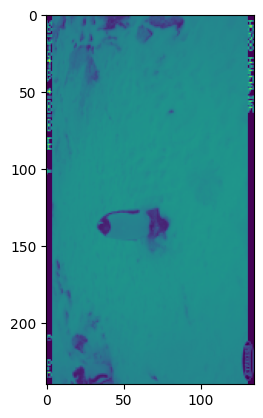

In [13]:
plt.imshow(img)

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0005)
num_epochs = 5

In [ ]:
model.to(device)
for epochs in range(num_epochs):
    print('iniciando epoch')
    epoch_loss = 0
    i = 0
    for data in train_dl :
        print(i)
        i += 1
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['label'].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)

In [18]:
loss

tensor(0.5420, dtype=torch.float64, grad_fn=<AddBackward0>)

In [58]:
folder = 'data/low_resolution/'
train = pd.read_csv('bboxes_separadas.csv')
train = train.drop(columns = 'Unnamed: 0')
im_names = train['imName'].unique()[:5000]
ig = Image.open(folder+im_names[1000]+'.JPG')

In [60]:
transform = T.ToTensor()
img = transform(ig)

In [ ]:
model.eval()

In [63]:
with torch.no_grad():
    pred = model([img])

In [69]:
bboxes, labels, scores = pred[0]['boxes'], pred[0]['labels'], pred[0]['scores']

In [65]:
scores

tensor([0.9971, 0.9947, 0.9944, 0.9932, 0.9910, 0.9884, 0.9870, 0.9814, 0.9808,
        0.9791, 0.9738, 0.9702, 0.9694, 0.9684, 0.9107, 0.8958, 0.8394, 0.8092,
        0.7681, 0.7558, 0.6702, 0.6028, 0.5740, 0.5049, 0.4551, 0.4484, 0.4347,
        0.4328, 0.4303, 0.4160, 0.3608, 0.3254, 0.3157, 0.2619, 0.2594, 0.2556,
        0.2433, 0.2381, 0.2131, 0.2090, 0.2002, 0.1935, 0.1805, 0.1645, 0.1607,
        0.1581, 0.1228, 0.1019, 0.1000, 0.0999, 0.0973, 0.0905, 0.0897, 0.0874,
        0.0869, 0.0848, 0.0793, 0.0762, 0.0735, 0.0720, 0.0663, 0.0656, 0.0643,
        0.0634, 0.0633, 0.0583, 0.0579, 0.0576, 0.0571, 0.0540, 0.0509, 0.0507,
        0.0502])

In [79]:
num = torch.argwhere(scores > 0.5).shape[0]

In [80]:
font = cv2.FONT_HERSHEY_SIMPLEX

In [81]:
igg = cv2.imread(folder+im_names[1000]+'.JPG')
for i in range(num) :
    x1, y1, x2, y2 = bboxes[i].numpy().astype('int')
    class_name =  'penguin'
    igg = cv2.rectangle(igg, (x1, y1), (x2, y2), (0, 255, 0), 1)
    igg = cv2.putText(igg, class_name, (x1, y1-10), font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

In [84]:
type(igg)

numpy.ndarray

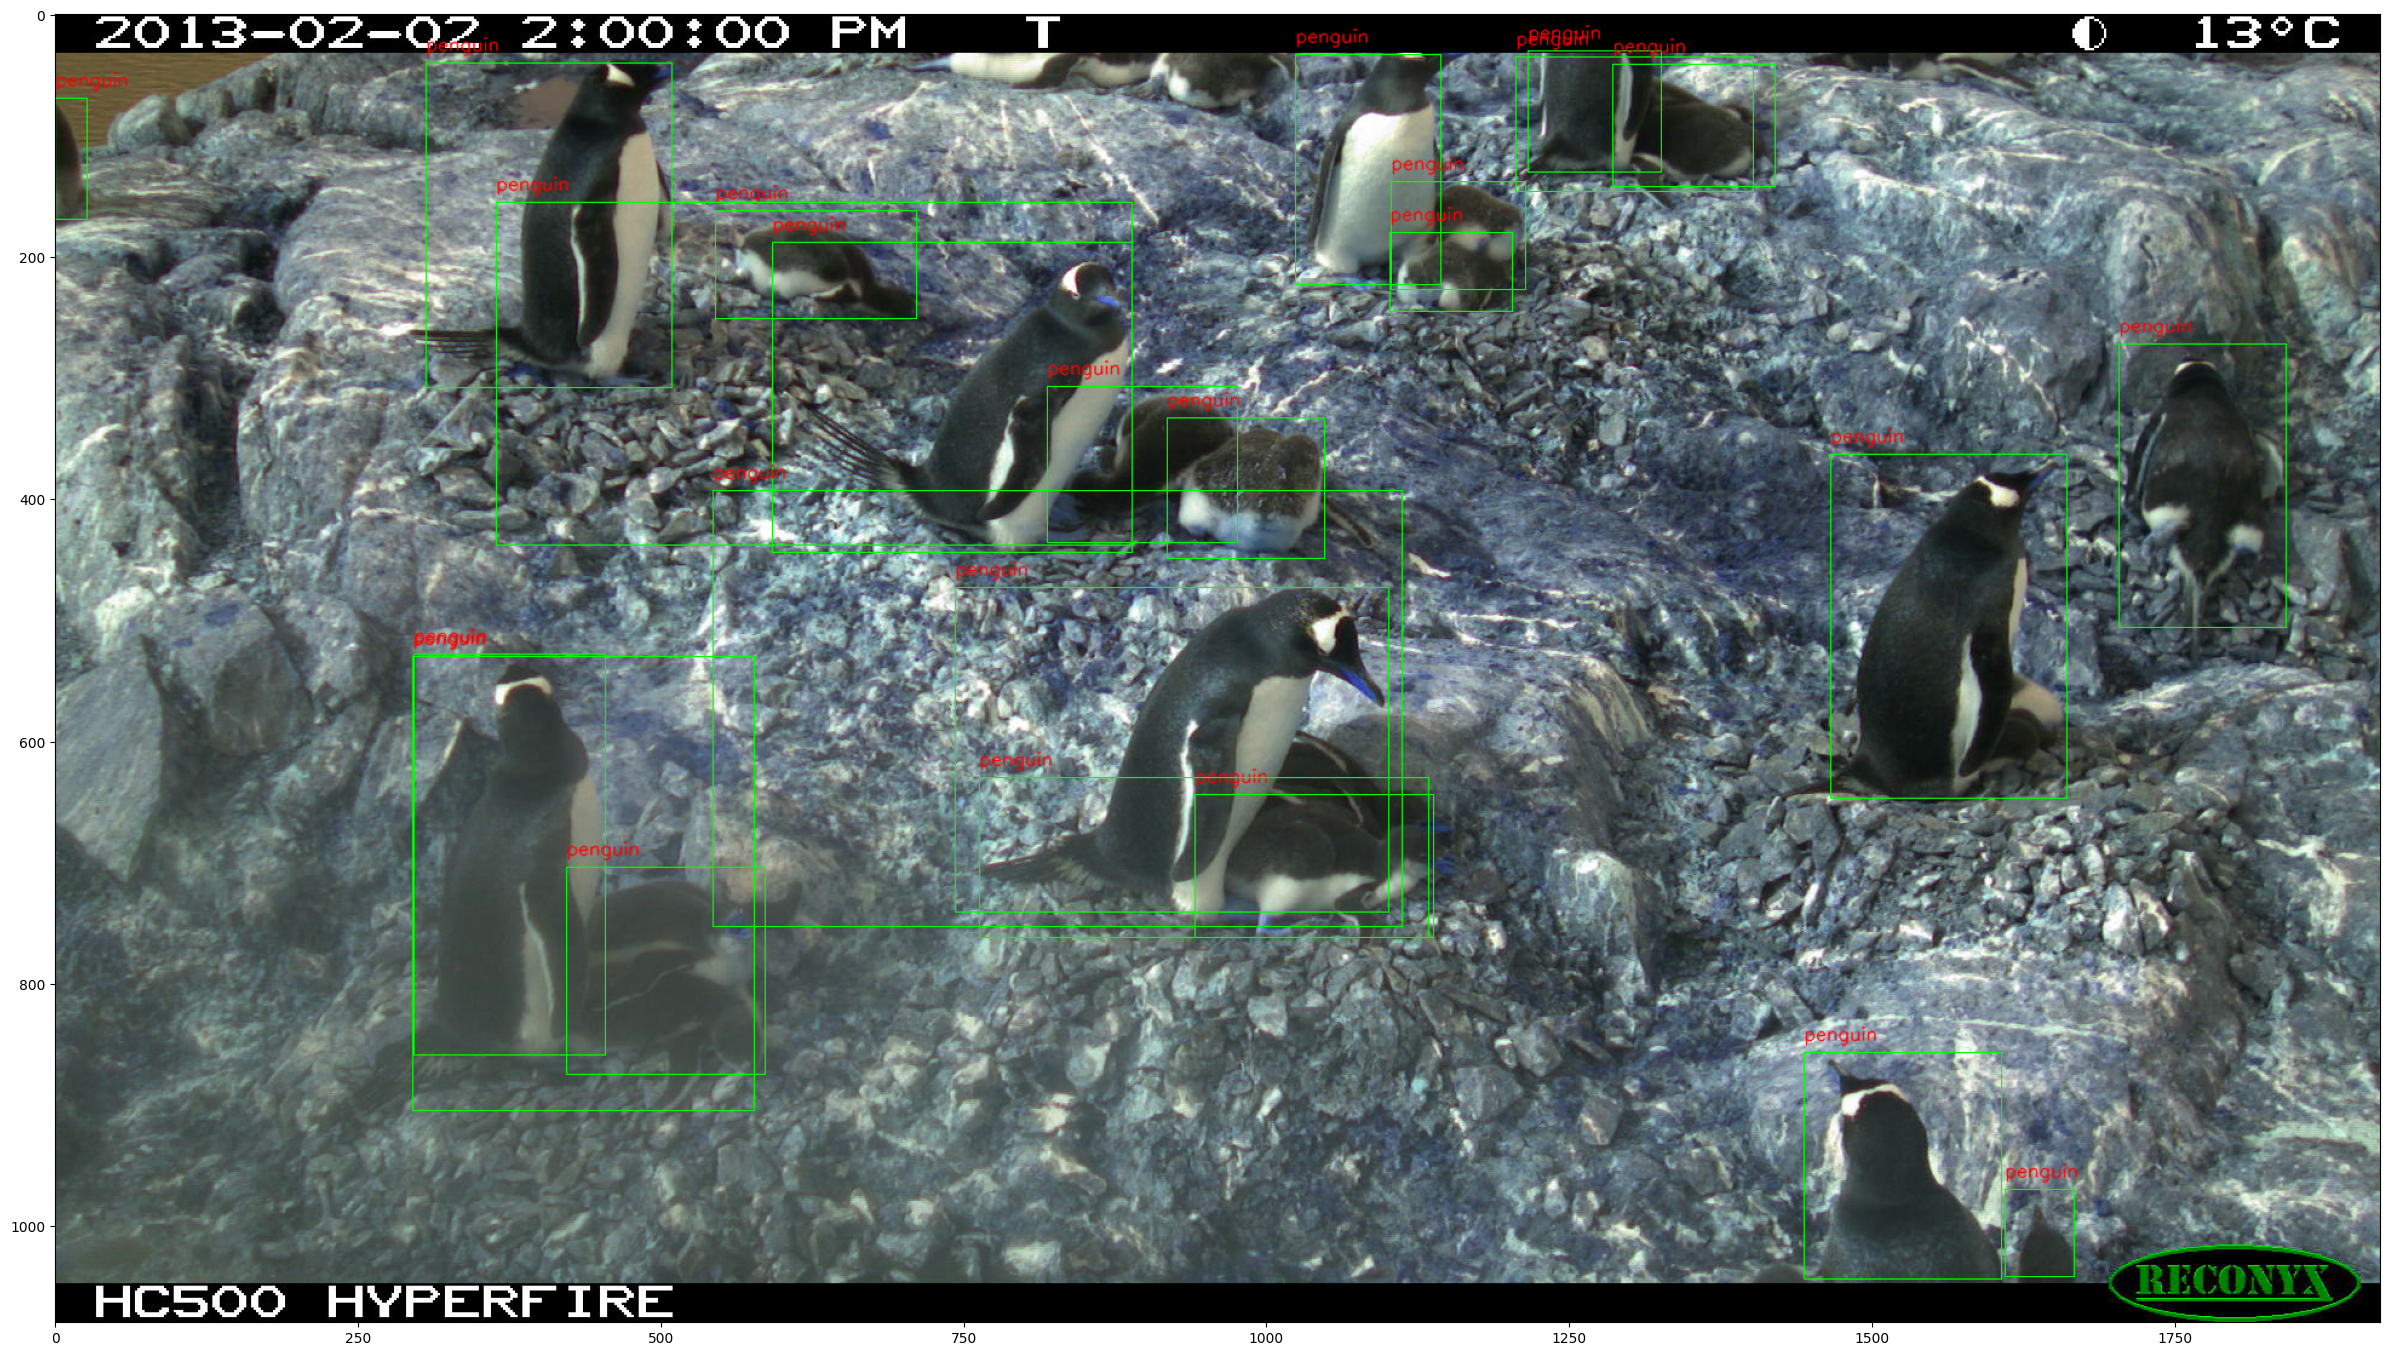

In [82]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
plt.figure(figsize=(30,30))
plt.imshow(igg)
plt.show()

#

In [66]:
torch.save(model.state_dict(), 'model_w_our_dataset.pt')

In [ ]:
#torch.save(model.state_dict(), '/home/jupyter/')
path = '/home/jupyter/uns-model.pth'
torch.save(model, path)

model_2 = torch.load(path)

In [85]:
torch.save(model, 'model_prod.pt')